# Simple SIR modeling with Python

Watch the videos first!!!

Readings for before or after:

* [All models are wrong, but some are completely wrong](https://rssdss.design.blog/2020/03/31/all-models-are-wrong-but-some-are-completely-wrong/)
* [Don’t Believe the COVID-19 Models](https://www.theatlantic.com/technology/archive/2020/04/coronavirus-models-arent-supposed-be-right/609271/)
* [https://fivethirtyeight.com/features/why-its-so-freaking-hard-to-make-a-good-covid-19-model/](https://fivethirtyeight.com/features/why-its-so-freaking-hard-to-make-a-good-covid-19-model/)

In [172]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

We'll need to use **differential equations** to calculate the population change over time. Luckily we can just [borrow this code](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/) and we'll be good!

> To understand this code, I recommend watching https://youtu.be/NKMHhm2Zbkw?t=119 - the timestamp I linked you to is where he starts walking through the equations below

In [173]:
# The SIR model differential equations.
def deriv(state, t, N, beta, gamma):
    S, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in I population over time
    dIdt = beta * S * I / N - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

We'll start by modeling our population. Having a thousand people and one infected person sounds reasonable.

**Effective contact rate** is `transmission rate * contact rate`, so:

* For example, 5% transmission rate and 5 contacts a day is `0.05 * 5 = 0.25`

**Recovery rate** is `1 / days`, so 

* For example, 4 day recovery rate is `1 / 4 = 0.25`

R0 is 2.0


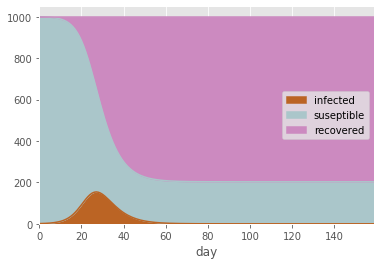

In [268]:
effective_contact_rate = 0.5
recovery_rate = 1/4

# We'll compute this for fun
print("R0 is", effective_contact_rate / recovery_rate)

# What's our start population look like?
# Everyone not infected or recovered is susceptible
total_pop = 1000
recovered = 0
infected = 1
susceptible = total_pop - infected - recovered

# A list of days, 0-160
days = range(0, 160)

# Use differential equations magic with our population
ret = odeint(deriv,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, effective_contact_rate, recovery_rate))
S, I, R = ret.T

# Build a dataframe because why not
df = pd.DataFrame({
    'suseptible': S,
    'infected': I,
    'recovered': R,
    'day': days
})

plt.style.use('ggplot')
df.plot(x='day',
        y=['infected', 'suseptible', 'recovered'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='area',
        stacked=True)

# If you get the error:
#
#     When stacked is True, each column must be either all
#     positive or negative.infected contains both...
#
# just change stacked=True to stacked=False

In [266]:
df

,suseptible,infected,recovered,day
0,999.000000,1.000000e+00,0.000000,0
1,998.156030,1.441507e+00,0.402463,1
2,996.941129,2.076462e+00,0.982409,2
3,995.194582,2.988037e+00,1.817381,3
4,992.688507,4.293468e+00,3.018025,4
...,...,...,...,...
155,177.651263,5.995464e-11,822.348737,155
156,177.651263,-4.403165e-11,822.348737,156
157,177.651263,-1.357693e-10,822.348737,157
158,177.651263,-2.152582e-10,822.348737,158


## Question 1

By default, the code above has an effective contact rate of 0.25 and a recovery rate of 0.1.

* If the transmission rate is 50%, how many contacts does an infected person have each day?
* How many days does it take to recover?

## Question 2

In the default scenario, it looks like the curve flattens out before everyone gets the disease. Can you explain what is happening?

## Question 3

**Run the code above**, with a population of 1000 people, 1 infected, and 0 recovered. Use an effective contact rate of 0.15 and a recovery rate of 3 weeks.

What is the maximum number of people sick at one time?

If there is a 1.5% case fatality rate, roughly how many people died after 160 days?

## Question 4

**Re-run the code with the settings above**, but use a population of 100,000 people.

What changes (or doesn't change) about the graph?

Many people would find the result surprising - explain why it looks like it does.

## Question 5

What happens to your infected population over time when you have an R0 of 1.0? **Use the notes for this, don't run a simulation.**

Now change your simulation: start with a population of 1000, where 200 are infected. Change your effective contact rate and recovery rate until you get an R0 of around 1.0.

What happens to your graph? I'm guessing it doesn't match what you predicted: why not?

## Question 6

If you were using this to model something like measles or the flu, you'd need to take into account immunization.

Can our SIR model use this information  without major changes, or do we need to find a new model?

## Question 7

The chart below contains case fatality rates by age, along with the percent of the population  that is in each age bracket.

|age|case fatality rate|percent of population|
|---|---|---|
|80+ years old|14.8%|3.6%|
|70-79 years old|8.0%|6.3%|
|60-69 years old|3.6%|11.2%|
|50-59 years old|1.3%|12.7%|
|below 50|0.2%|66.2m|

Let's say we're interested in using our model to predict how many people die from a disease. 

Can our SIR model use this information without major changes, or do we need to find a new model?

### Question 8

It has been said that children are more effective spreaders of disease, in that going to school helps them have a much contact rate (and thus a higher effective contact rate). Take the following breakdown as an example:

|age bracket|contact rate|percent of population|
|---|---|---|
|under 18|20.5|24.1%|
|18 and over|13.2|75.9%|

Can our SIR model use this information without major changes, or do we need to find a new model?

# Bonus: Flattening the curve

Now we're going to graph **two charts** instead of just one.

In [269]:
def adjust_rate(contact_rate, day):
    if day > 0:
        return contact_rate
    else:
        return contact_rate

# The SIR model differential equations.
def deriv_adjusted(state, t, N, beta, gamma):
    S, I, R = state
    
    beta = adjust_rate(beta, t)
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in I population over time
    dIdt = beta * S * I / N - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

R0 is 2.8000000000000003


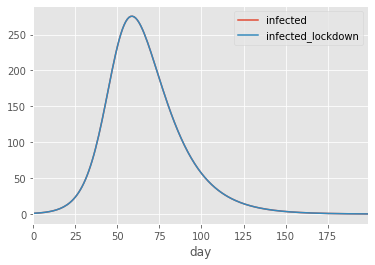

In [270]:
effective_contact_rate = 0.2
recovery_rate = 1/14

# We'll compute this for fun
print("R0 is", effective_contact_rate / recovery_rate)

# What's our start population look like?
# Everyone not infected or recovered is susceptible
total_pop = 1000
recovered = 0
infected = 1
susceptible = total_pop - infected - recovered

# A list of days
days = range(0, 200)

# First do it with our original derivation...
ret = odeint(deriv,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, effective_contact_rate, recovery_rate))
S, I, R = ret.T

# ...then do it again with the adjusted one.
ret = odeint(deriv_adjusted,
             [susceptible, infected, recovered],
             days,
             args=(total_pop, effective_contact_rate, recovery_rate))
S_adj, I_adj, R_adj = ret.T

# Build a dataframe because why not
df = pd.DataFrame({
    'infected': I,
    'infected_lockdown': I_adj,
    'day': days
})

plt.style.use('ggplot')
df.plot(x='day',
        y=['infected', 'infected_lockdown'])

# If you get the error:
#
#     When stacked is True, each column must be either all
#     positive or negative.infected contains both...
#
# just change stacked=True to stacked=False

Before we used `deriv` to make our calculations, which just used the normal contact rate we gave it.

This time we've made a new one: `deriv_adjusted`, which uses the `adjust_rate` function to change the contact rate over time.

Right now `adjust_rate` returns the same contact rate, **no matter what day it is**. See if you can flatten the curve by adjusting the contact rate after a month or so of unchecked spread!

> Note: Don't invent a new `contact_rate`, just multiply it or something!

## Question

Aren't you impressed with how easy it is to flatten the curve?????? I know I was!